In [895]:
import requests
from bs4 import BeautifulSoup
import re
import selenium
import time
import pandas as pd
import numpy as np
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import tqdm
import seaborn as sns

# Functions for extracting data and manipulating data

In [2]:
def getAndParseUrl(url):
    time.sleep(0.5)
    response = requests.get(url, headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15', 'Name':'Jeppe Gyland Götzsche', 'Email': 'pzb150@alumni.ku.dk', 'Purpose': 'We are gathering data for our examn project'})
    return (BeautifulSoup(response.content, 'html.parser'))

In [3]:
def NumberAndAge(data):
    Number = []
    Age = []
    x=0
    y=1
    for i in range(50):
        if i < 25:
            Number.append(data[x].text)
            x+=4
            i+=1
        elif i <50: 
            Age.append(data[y].text)
            y+=4
            i+=1
    return Number, Age

In [4]:
def PlayerFromToPrice(data):

    Name = []
    From = []
    To = []
    Price = []
    
    x=0
    y=1
    z=2
    w=3
    i = 0
    for i in range(len(data)):
        if i < 25:
            Name.append(data[x].text.strip())
            x+=4
            i+=1
        elif i < 50:
            From.append(data[y].text.strip())
            y+=4
            i+=1
        elif i < 75:
            To.append(data[z].text.strip())
            z+=4
            i+=1
        elif i < 100:
            Price.append(data[w].text.strip())
            w+=4
            i+=1
    return Name, From, To, Price

In [5]:
def LeftJoined(data):
    
    LeftJoined_data = data.find_all('table', {'class': 'inline-table'})
    
    Left_League = []
    Joined_League = []
    Position = []
    
    i=0
    w=0
    x=1
    y=2
    for i in range(75):
        if i < 25:
            #One player returned from a football Ban, and thus we had to account for this
            if LeftJoined_data[x].text.replace('\n', '').split('  ')[0].strip() == 'Ban':
                Left_League.append(LeftJoined_data[x].text.replace('\n', '').split('  ')[0].strip())
                x+=3
            else:
                Left_League.append(LeftJoined_data[x].text.replace('\n', '').split('  ')[1].strip()) 
                i+=1
                x+=3
        elif i < 50:
            Joined_League.append(LeftJoined_data[y].text.replace('\n', '').split('  ')[1].strip()) 
            y+=3
            i+=1
        elif i <75:
            Position.append(LeftJoined_data[w].text.replace('\n', ' ').strip().split('    ')[1])
            w+=3
            
    return Position, Left_League, Joined_League

In [6]:
def MarketValue(Data):
    Market = []
    x=0
    for i in Data:
        if (x % 2) == 0:
            Market.append(i.text)
        x+=1
    return Market

In [7]:
def Nationalitet(data):
    nats = []
    for td in data.findAll("td", class_="zentriert"): 
            inner_grp = []
            for item in td.findAll("img", class_="flaggenrahmen", title=re.compile("^(?!http).*")):
                if item.get('title'):
                    inner_grp.append(item.get('title'))
            if inner_grp:
                nats.append(inner_grp)
    Nationalitet = []
    x=0
    for i in nats:
        if (x%2)==0:
            Nationalitet.append(", ".join(i))
        x+=1
    return Nationalitet

In [8]:
def season_id(data, tal):
    return (pd.Series(data.find_all('div', {'class': 'inline-select'})[0].text.split()[tal]).repeat(25))

In [9]:
#Function for replacing € and making them integers
def get_num(data):
    
    lokal = []
    for x in data:
        no_euro = x.replace('€', '')
        if 'm' in x:
            lokal.append(int(no_euro.replace('m', '0.000').replace('.', '')))
        elif 'Th.' in x:
            lokal.append(int(no_euro.replace('Th.', '.000').replace('.','')))
        else:
            lokal.append(int(no_euro.replace('€', '')))
    return lokal

In [10]:
#Function for determining distinct values
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)

# Extracting the Transfer Data

In [860]:
#Defining the different lists
Number = []
Name = []
Age = []
Position = []
Nationality = []
Market = []
From = []
Left_League = []
To = []
Joined_League = []
Price = []
tal = 2
temp = []

start_time = time.time()

#Seasons*
for i in tqdm.tqdm(range(20)): #Different seasons
    for j in range(1,11): # Amount of pages to scroll through
        #Generer suppe
        url = f'https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/plus/1/galerie/0?saison_id={2021-i}&transferfenster=alle&land_id=&ausrichtung=&spielerposition_id=&altersklasse=&leihe=&page={j}'
        suppe = getAndParseUrl(url)

        #Generate Datasets
        NumberAndAge_data = suppe.find_all('td',{'class':'zentriert'})
        Name_data = suppe.find_all('td', {'class' : 'hauptlink'})
        Market_data = suppe.find_all('td', {'class' : 'rechts'})
        
        #Extracting the data
        Number, Age = NumberAndAge(NumberAndAge_data)
        Nationality = Nationalitet(suppe)
        Market = MarketValue(Market_data)
        Name, From, To, Price = PlayerFromToPrice(Name_data)
        Position, Left_League, Joined_League = LeftJoined(suppe) 
        season = season_id(suppe, tal)
        temp.append(pd.DataFrame({'No.': Number, 'Name': Name, 'Age': Age, 'Position': Position, 'Nationality': Nationality, 'Market Value': Market,'Left': From, 'League left': Left_League, 'Joined': To, 'Joined League': Joined_League ,'Price': Price, 'Season': season}).set_index('No.'))
    tal+=1
print("--- %s seconds ---" % round((time.time()- start_time), 2))

100%|██████████| 20/20 [11:58<00:00, 35.90s/it]

--- 718.04 seconds ---


In [862]:
#Save to CSV-file
data = pd.concat(temp,axis=0).reset_index(drop=True).replace('?', 'Undisclosed').replace('-', 'Undisclosed')
data.to_csv('Transfer details - season - position.csv')

# Extracting Player Data (Saves as CSV file)

### DO NOT RUN AGAIN

In [543]:
x =

SyntaxError: invalid syntax (<ipython-input-543-b36cc2387d25>, line 1)

In [ ]:
#find all hrefs
player_href = [] # define container to the hyperlinks
player = []
url = []
for s in tqdm.tqdm(range(20)): #Når alt skal hentes, så sættes dette til 20
    url = 'https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/plus/0/galerie/0?saison_id=' + str(2021 - s)
    for i in range(1,11): #Når alt skal hentes, så sættes dette til 10
        k = url +'&page=' + str(i)
        response = requests.get(k,headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15','name':'Lucas','mail':'rtq618@alumni.ku.dk','Purpose':'Scraping for exam project'})
        soup = BeautifulSoup(response.text,'html.parser') # parse the raw html using BeautifoulSoup
        player = soup.findAll('a',{'class':'spielprofil_tooltip'})
        for x in range(25):
            player_href.append(player[x]['href'])   
        time.sleep(0.001)

### DO NOT RUN AGAIN

In [ ]:
#Player name extraction
player_links = []
player_name = []
player_id = [] 
url = []
n = []
for i in range(0,len(player_href)): #deler hver href til forskellige strings
    player_links.append(player_href[i].split(sep='/'))

for i in range(0,len(player_links)): #udvælger kun spillernavnet
    player_name.append(player_links[i][1])
    player_id.append(player_links[i][4])
    
#Links to the stats page for the season before they were sold:
i=0
for (k,y) in zip(player_name,player_id):
    url.append('https://www.transfermarkt.com/' + k +'/leistungsdaten/spieler/' + y +'/saison/' + str(2020-i)+'#gesamt')
    if len(url)%250 ==0:
        i+=1

### DO NOT RUN AGAIN

In [ ]:
#Get data from every player
header = ['Matches_played','Goals','Assist','Yellow Card', 'Yellow to red card', 'Red card']
df = []
name = []
Mathches_played= []
goals =[]
assist = []
yellow = []
yellow_to_red = []
red = []
Minutes = []

for link in tqdm.tqdm(url):
    #Creating soup
    resp = requests.get(link, headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15','name':'Lucas','mail':'rtq618@alumni.ku.dk','Purpose':'Scraping for exam project'})
    soup = BeautifulSoup(resp.text,'html.parser') # parse the raw html using BeautifoulSoup
    
    
    if soup.findAll('span',{'class':'empty'}):
        name.append(soup.find('h1').text)
        Mathches_played.append('None')
        goals.append('None')
        assist.append('None')
        yellow.append('None')
        yellow_to_red.append('None')
        red.append('None')
        Minutes.append('None')
    else:
        #Extracting info
        name.append(soup.find('h1').text)
        data = soup.findAll('td',{'class':'zentriert'})
        Mathches_played.append(data[0].text)
        goals.append(data[1].text)
        assist.append(data[2].text)
        yellow.append(data[3].text)
        yellow_to_red.append(data[4].text)
        red.append(data[5].text)
        Minutes.append(soup.findAll('td',{'class':'rechts'})[1].text)
    time.sleep(0.0001)

#Puts it into a dataframe
df = pd.DataFrame({'Name':name,'Mathches_played':Mathches_played,'Goals':goals,'Assist':assist, 'Yellow_cards':yellow,'Yellow_to_red':yellow_to_red,'Red_cards':red,'Minutes_played':Minutes})
full_frame = df.replace('-','0')
full_frame.to_csv('Full_data.csv')

# Data Structuring

In [954]:
###Loading CSV Files

#open Transfer Details.csv
Player_transfer = pd.read_csv('Transfer details - season - position.csv', index_col = 'Unnamed: 0')

#Open Spiller Statistik.csv:
cols = ['Name1', 'Matches_played', 'Goals', 'Assist', 'Yellow_cards', 'Yellow_to_red', 'Red_cards', 'Minutes_played']
Player_stats = pd.read_csv('Spiller statistik.csv', index_col = 'Unnamed: 0')
Player_stats.columns = cols

In [955]:
#Merging the two dataframes:
Samlet = pd.concat([Player_transfer, Player_stats], axis = 1)

#Verifying that the names match:
column = Samlet.iloc[:, 0] == Samlet.iloc[:, 11]

Samlet['Check'] = column

#given that our two different csv files were scraped at different times, they may differ. 
#Therefore we remove set columns where the names have been displaced
#Furthermore we remove rows where the player stats were not defined, free transfers and loan transfers
Correct_names = Samlet[Samlet['Check'] == True]
No_Free = Correct_names[Correct_names['Price'] != 'free transfer']
No_Loan = No_Free[No_Free['Price'] != 'loan transfer']
No_MarketValue = No_Loan[No_Loan['Market Value'] != 'Undisclosed']
No_Undisc = No_MarketValue[No_MarketValue['Price'] != 'Undisclosed']

#Removing goalkeepers since their stats have a different format
No_Keeper = No_Undisc[No_Undisc['Position'] != 'Goalkeeper']
No_None = No_Keeper[No_Keeper['Goals'] != 'None'].reset_index(drop=True)

#We noticed we had loan fees in our data which might confuse our model
#we removed these rows
index = []
x= 0
for i in No_None['Price']:
    if 'Loan' in i:
        index.append(x)
    x+=1

No_LoanFee = No_None.drop(labels=index,axis=0).reset_index(drop=True)

In [956]:
#Minutes to int
min_int = []
for i in No_LoanFee['Minutes_played']:
    min_int.append(int(i.replace("'",'').replace('.','')))
    
No_LoanFee['Minutes_played'] = min_int

In [957]:
#Now we convert the market values and transfer fees to integers
Market = list(No_LoanFee['Market Value'])
Transfer = list(No_LoanFee['Price'])

Market_tal = get_num(Market)
Price_tal = get_num(Transfer)

In [958]:
No_LoanFee['Market Value'] = Market_tal
No_LoanFee['Price'] = Price_tal
Final_data = No_LoanFee.drop(No_LoanFee.columns[[11, 19]],axis=1)

#Checking what columns are not integers
Final_data.dtypes

#By studying our data, we find that deceased players as Emiliano Sala has a cross next to their age.
#We remove this

Alder = list()
for x in Final_data['Age']:
    if '†' in x:
        Alder.append(x.replace('†',''))
    else:
        Alder.append(x)
Final_data['Age'] = Alder

#Converting to integers and thus we have our final dataset
Final_data[['Age', 'Matches_played', 'Goals', 'Assist', 'Yellow_cards', 'Yellow_to_red', 'Red_cards']] = Final_data[['Age', 'Matches_played', 'Goals', 'Assist', 'Yellow_cards', 'Yellow_to_red', 'Red_cards']].apply(pd.to_numeric)

In [959]:
#Defining three different lists for each player
Attack = ['Left Winger', 'Centre-Forward', 'Right Winger', 'Second Striker']
Midfield = ['Central Midfield', 'Defensive Midfield', 'Attacking Midfield', 'Left Midfield', 'Right Midfield']
Defence = ['Centre-Back', 'Left-Back', 'Right-Back']

In [960]:
#Assigning different players to the different categories in order to minimize dummies
Positions_new = []
for pos in Final_data['Position']:
    if pos in Attack:
        Positions_new.append('Attack')
    elif pos in Midfield:
        Positions_new.append('Midfield')
    else: 
        Positions_new.append('Defence')
        
Final_data['Position'] = Positions_new

In [961]:
#We have 75 different leagues, and to minimize dummies, we categorize these
#We have divided our 75 leagues in to 3 different lists based on their ranking 
Best_leagues = ['Premier League', 'Bundesliga', 'Ligue 1', 'LaLiga', 'Serie A', 'Primera División', 'Liga BBVA']

Medium_leagues = ['Liga NOS', 'Eredivisie', 'Série A', 'Primera Division', 'Liga Bwin', 'Championship',
           'Premier Liga', 'Brazil', 'Süper Lig', 'MLS', 'Liga MX Clausura', 'Liga Sagres', 'Russia', 'Jupiler Pro League',
                  'Jupiler League', 'Pro League']

Bad_leagues = ['Serie B', '2. Bundesliga', 'Premier League 2', '1.HNL', 'Liga Profesional',
           'Premiership', 'Superligaen', 'Super League 1', 'Super League',
           'LaLiga2', 'Fortuna Liga', 'Copa de la Liga', 'Ligue 2', 'Liga 1 - Championship group',
           'Ekstraklasa', 'Copa Maradona', 'Stars League', '2ª B - Grupo I', 'Efbet liga - Championship gr.', 
           'Rel. Ligue 1', 'League One', 'UAE Pro League', 'Liga DIMAYOR II', 'Superliga', 'Professional League', 
          '2ª B - Grupo III', 'Transición', 'Jelen SuperLiga', 'Primavera A', 'Liga 1', 'Gambrinus Liga', 'Torneo Final', 
          'Liga Postobón II', 'Primera B', 'Ascenso MX Cl.', 'Russia', 'Friendlies', 'Liga de Ascenso', 'Primera Clausura', 
          'United Arab Emirates', 'Qatar', 'J.League Div.1', 'Lega Pro 1 - B', 'Vyshcha Liga', 'Série B', 'Chile', 
          'Meridian Super', 'SAS Ligaen', 'Serie C1 - A', 'Meridian Prva', 'Argentina', 'SuperLiga', 
          'Primera Apertura', 'Croatia', '2ª División', 'A Ethniki']

In [962]:
#Left leagues:
League_new = []
for Leagues in Final_data['League left']:
    if Leagues in Best_leagues:
        League_new.append('Top Leagues, left')
    elif Leagues in Medium_leagues:
        League_new.append('Medium Leagues, left')
    else: 
        League_new.append('Worst Leagues, left')
        
Final_data['League left']=League_new

In [963]:
#unique(Final_data['Joined League'])

In [964]:
#Joined leagues:
League_new2 = []
for Leagu in Final_data['Joined League']:
    if Leagu in Best_leagues:
        League_new2.append('Top Leagues, joined')
    elif Leagu in Medium_leagues:
        League_new2.append('Medium Leagues, joined') 
    else:
        League_new2.append('Worst Leagues, joined')
Final_data['Joined League']=League_new2

In [965]:
#We noticed that some players had two nationalities. Python thought that these
#two countries were one country.
Nationality = list()
for country in Final_data['Nationality']:
    Nationality.append(country.split(',')[0])

Final_data['Nationality'] = Nationality

In [966]:
#We sorted every country into regions, as we think that the region might affect the transfer fee.
GB = ['England','Wales','Ireland','Northern Ireland','Scotland']
Eu_east = ['Ukraine','Romania','Poland','Czech Republic','Bosnia-Herzegovina','Hungary','Kosovo','Russia',
          'Serbia','Slovakia','North Macedonia','Armenia','Slovenia','Montenegro','Bulgaria','Albania',
          'Belarus']
Eu_south = ['Italy','Croatia','Greece','Switzerland', 'Portugal','Spain']
Eu_north = ['Belgium','France','Netherlands','Germany','Austria', 'Denmark',
            'Norway','Sweden','Iceland','Finland']
Am_north = ['Jamaica','United States','Dominican Republic','Canada','Mexico']
Am_south = ['Argentina','Brazil','Colombia','Uruguay','Ecuador','Venezuela','Chile','Paraguay','Martinique',
           'Peru','Curacao','Honduras','Costa Rica','Trinidad and Tobago','Guadeloupe','Bolivia','French Guiana']
APAC = ['Uzbekistan','Korea','Japan','New Zealand','China','Kazakhstan','Australia']
Africa = ['Morocco', 'Zambia',"Cote d'Ivoire",'The Gambia','Ghana','Senegal','Algeria','Gabon','Nigeria','Burkina Faso',
         'Angola','Central African Republic','Cameroon','Guinea','Mali','DR Congo','Egypt','Benin', 'Kenya', 'Burundi',
          'Tunisia','Congo','Togo','South Africa','Zimbabwe']
Middle_east = ['Iran', 'Turkey','Israel','United Arab Emirates','Saudi Arabia','Qatar']

In [967]:
#Sorting countries:
region = []
for C in Final_data['Nationality']:
    if C in GB:
        region.append('Great Britain')
    elif C in Eu_east:
        region.append('Eastern Europe') 
    elif C in Eu_south:
        region.append('Western Europe')
    elif C in Eu_north:
        region.append('Northern Europe')
    elif C in Am_north:
        region.append('Northern America')
    elif C in Am_south:
        region.append('Southern America')
    elif C in APAC:
        region.append('Asia Pacific')
    elif C in Africa:
        region.append('Africa')
    else:
        region.append('Middle East')
Final_data['Nationality'] = region

## Machine Learning Part

In [968]:
#To use these data in our model we have to take the season into account.
#We think the season that a player transfers might affect the price. To take this into account
#We've found a website which shows the european football market value from 2006/2007 till 2018/2019
#From here we've put the numbers into excel and let excel use the data to estimate more data going on to 2002/2003 and 2021/2022
#This might be a bad idea.
#Then we've used the data and found the yearly growth. This will be scalars we add to the players transfer fee.
scalar_price = list()
for season, price in zip(Final_data['Season'],Final_data['Price']):
    if season == '21/22':
        scalar_price.append(price*0.23)
    elif season == '20/21':
        scalar_price.append(price*0.27)
    elif season == '19/20':
        scalar_price.append(price*0.3)
    elif season == '18/19':
        scalar_price.append(price*0.34)
    elif season == '17/18':
        scalar_price.append(price*0.41)
    elif season == '16/17':
        scalar_price.append(price*0.44)
    elif season == '15/16':
        scalar_price.append(price*0.47)
    elif season == '14/15':
        scalar_price.append(price*0.49)
    elif season == '13/14':
        scalar_price.append(price*0.51)
    elif season == '12/13':
        scalar_price.append(price*0.58)
    elif season == '11/12':
        scalar_price.append(price*0.60)
    elif season == '10/11':
        scalar_price.append(price*0.64)
    elif season == '09/10':
        scalar_price.append(price*0.66)
    elif season == '08/09':
        scalar_price.append(price*0.74)
    elif season == '07/08':
        scalar_price.append(price*0.77)
    elif season == '06/07':
        scalar_price.append(price*0.86)
    elif season == '05/06':
        scalar_price.append(price*0.87)
    elif season == '04/05':
        scalar_price.append(price*0.90)
    elif season == '03/04':
        scalar_price.append(price*0.93)
    elif season == '02/03':
        scalar_price.append(price)
    
Final_data['Price'] = scalar_price

In [969]:
scalar_mv = list()
for season, price in zip(Final_data['Season'],Final_data['Market Value']):
    if season == '21/22':
        scalar_mv.append(price*0.23)
    elif season == '20/21':
        scalar_mv.append(price*0.27)
    elif season == '19/20':
        scalar_mv.append(price*0.3)
    elif season == '18/19':
        scalar_mv.append(price*0.34)
    elif season == '17/18':
        scalar_mv.append(price*0.41)
    elif season == '16/17':
        scalar_mv.append(price*0.44)
    elif season == '15/16':
        scalar_mv.append(price*0.47)
    elif season == '14/15':
        scalar_mv.append(price*0.49)
    elif season == '13/14':
        scalar_mv.append(price*0.51)
    elif season == '12/13':
        scalar_mv.append(price*0.58)
    elif season == '11/12':
        scalar_mv.append(price*0.60)
    elif season == '10/11':
        scalar_mv.append(price*0.64)
    elif season == '09/10':
        scalar_mv.append(price*0.66)
    elif season == '08/09':
        scalar_mv.append(price*0.74)
    elif season == '07/08':
        scalar_mv.append(price*0.77)
    elif season == '06/07':
        scalar_mv.append(price*0.86)
    elif season == '05/06':
        scalar_mv.append(price*0.87)
    elif season == '04/05':
        scalar_mv.append(price*0.90)
    elif season == '03/04':
        scalar_mv.append(price*0.93)
    elif season == '02/03':
        scalar_mv.append(price)
    
Final_data['Market Value'] = scalar_mv

In [970]:
# getting the dummies
features = pd.get_dummies(Final_data, columns = ['League left', 'Joined League','Nationality', 'Position']).drop(['Season','Left', 'Joined'], axis = 1)

In [971]:
# Labels are the values we want to predict
labels = np.array(features['Price'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['Price'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [972]:
# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [973]:
#We look at the shape of all the data to make sure we did everything correctly. 
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2095, 27)
Training Labels Shape: (2095,)
Testing Features Shape: (699, 27)
Testing Labels Shape: (699,)


In [974]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

#ignorer denne celle
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 2303373.93 degrees.


In [975]:
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy: 45.87 %.
Variable: Age                  Importance: 0.7
Variable: Name                 Importance: 0.06
Variable: Red_cards            Importance: 0.05
Variable: Goals                Importance: 0.04
Variable: Market Value         Importance: 0.03
Variable: Matches_played       Importance: 0.03
Variable: Assist               Importance: 0.03
Variable: Yellow_to_red        Importance: 0.01
Variable: Nationality_Eastern Europe Importance: 0.01
Variable: Nationality_Northern America Importance: 0.01
Variable: Yellow_cards         Importance: 0.0
Variable: Minutes_played       Importance: 0.0
Variable: League left_Medium Leagues, left Importance: 0.0
Variable: League left_Top Leagues, left Importance: 0.0
Variable: League left_Worst Leagues, left Importance: 0.0
Variable: Joined League_Medium Leagues, joined Importance: 0.0
Variable: Joined League_Top Leagues, joined Importance: 0.0
Variable: Joined League_Worst Leagues, joined Importance: 0.0
Variable: Nationality_Africa   Impor

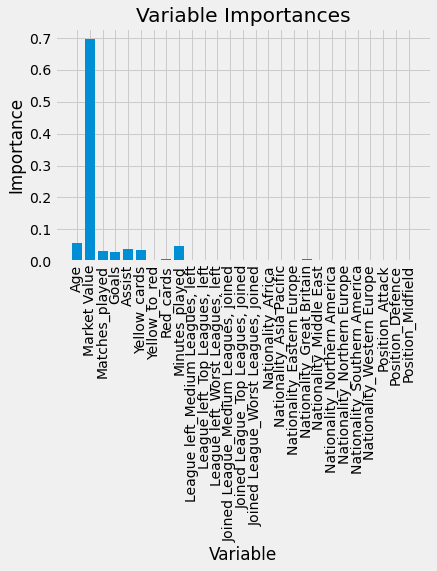

In [867]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

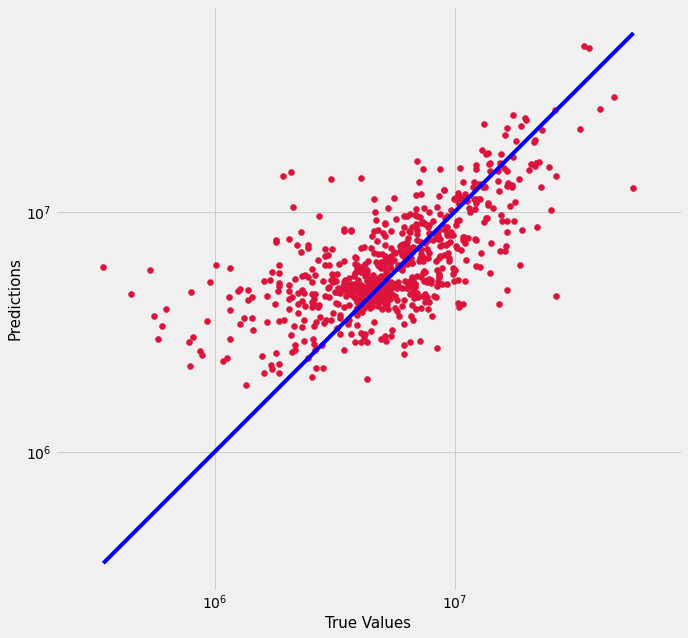

In [894]:
plt.figure(figsize=(10,10))
plt.scatter(test_labels, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(test_labels))
p2 = min(min(predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<AxesSubplot:xlabel='Nationality', ylabel='Price'>

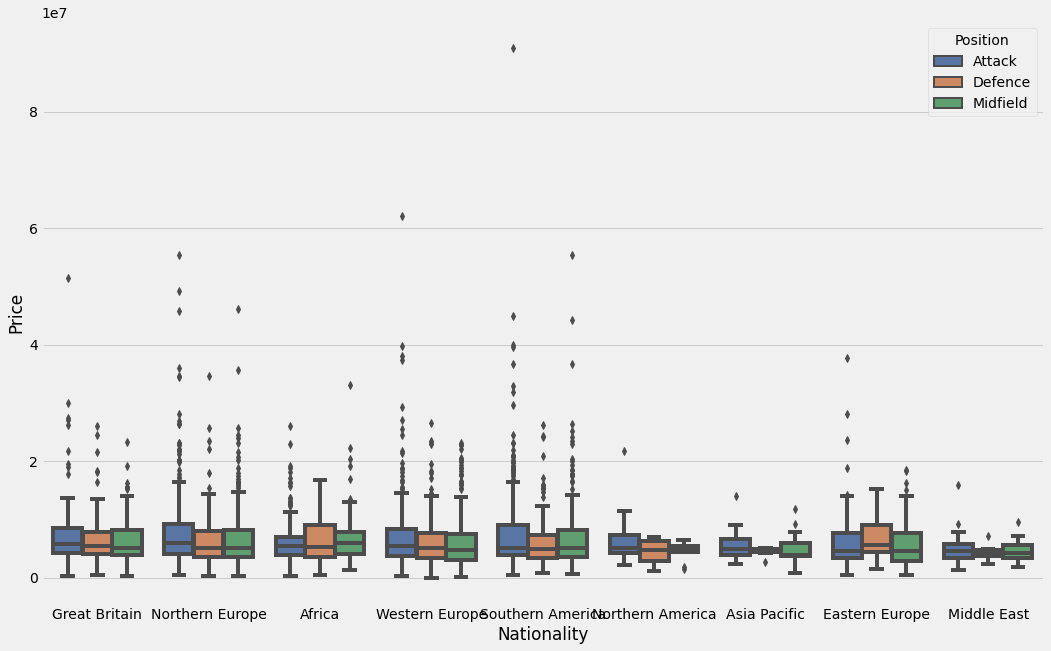

In [901]:
f2, ax =plt.subplots(figsize=(16,10))
sns.boxplot(data = Final_data, x = 'Nationality', y='Price', hue='Position', palette='deep')

In [897]:
Final_data

,Name,Age,Position,Nationality,Market Value,Left,League left,Joined,Joined League,Price,Season,Matches_played,Goals,Assist,Yellow_cards,Yellow_to_red,Red_cards,Minutes_played
0,Jack Grealish,25,Attack,Great Britain,14950000.0,Aston Villa,"Top Leagues, left",Man City,"Top Leagues, joined",27025000.0,21/22,27,7,12,5,0,0,2275
1,Romelu Lukaku,28,Attack,Northern Europe,23000000.0,Inter,"Top Leagues, left",Chelsea,"Top Leagues, joined",26450000.0,21/22,44,30,10,7,0,0,3565
2,Jadon Sancho,21,Attack,Great Britain,23000000.0,Bor. Dortmund,"Top Leagues, left",Man Utd,"Top Leagues, joined",19550000.0,21/22,38,16,20,1,0,0,2974
3,Raphaël Varane,28,Defence,Northern Europe,16100000.0,Real Madrid,"Top Leagues, left",Man Utd,"Top Leagues, joined",9200000.0,21/22,41,2,0,4,0,0,3571
4,Achraf Hakimi,22,Defence,Africa,13800000.0,Inter,"Top Leagues, left",Paris SG,"Top Leagues, joined",13800000.0,21/22,45,7,11,9,0,0,3211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,Fabio Cannavaro,28,Defence,Western Europe,6500000.0,AC Parma,"Top Leagues, left",Inter,"Top Leagues, joined",23000000.0,02/03,45,1,0,11,1,1,3983
2790,Stephen Appiah,21,Midfield,Africa,1000000.0,AC Parma,"Top Leagues, left",Brescia,"Top Leagues, joined",4550000.0,02/03,23,0,0,2,0,0,1038
2791,Nick Barmby,28,Midfield,Great Britain,600000.0,Liverpool,"Top Leagues, left",Leeds,"Top Leagues, joined",4500000.0,02/03,12,0,0,1,0,0,629
2792,Andrés Fleurquín,27,Midfield,Southern America,100000.0,Sturm Graz,"Top Leagues, left",Stade Rennais,"Top Leagues, joined",2000000.0,02/03,36,3,2,11,0,0,2149
